In [1]:
from bounds import bounds
import matplotlib.pyplot as plt
import numpy as np
import ast
from cooper_standard import CooperStandard

/home/mohammad/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Example usage
file_path = "DataOn2025Jan08.xlsx"
sheet_names = ["NES2060C05Line2", "NES2060C06Line2"]
variables = ["batch_number", "MDRTorqueS1", "MDRTorqueS2", 
             "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min", "start_time", "end_time", "t5"]

cooper_standard = CooperStandard(file_path, sheet_names, variables)
df_all = cooper_standard.load_data()
df_vars = cooper_standard.df_variables()
cleaned_df, removed_batches = cooper_standard.preprocessing(280)
lb, ub = bounds["2060C05"][0], bounds["2060C05"][1]  # Assuming bounds is defined elsewhere
#df_low, df_normal, df_high = cooper_standard.categorize_t5(lb, ub)

# Convert to dictionary
df_normal_dict = cooper_standard.convert_to_dict(cleaned_df)

# Split the data
train_dict, val_dict, test_dict = cooper_standard.split_data(df_normal_dict, random_state=42)

# Normalize using training data statistics
train_dict_norm = cooper_standard.normalize_data(train_dict, fit=True)
val_dict_norm = cooper_standard.normalize_data(val_dict, fit=False)
test_dict_norm = cooper_standard.normalize_data(test_dict, fit=False)

cooper_standard.print_t5_categories(train_dict_norm, lb, ub)
cooper_standard.print_t5_categories(val_dict_norm, lb, ub)
cooper_standard.print_t5_categories(test_dict_norm, lb, ub)

Total number of batches: 3238
Number of low batches (t5 < 3.5): 790
Number of normal batches (3.5 <= t5 <= 5.0): 2289
Number of high batches (t5 > 5.0): 159

Total number of batches: 694
Number of low batches (t5 < 3.5): 166
Number of normal batches (3.5 <= t5 <= 5.0): 491
Number of high batches (t5 > 5.0): 37

Total number of batches: 695
Number of low batches (t5 < 3.5): 165
Number of normal batches (3.5 <= t5 <= 5.0): 499
Number of high batches (t5 > 5.0): 31



In [3]:
print(f"number of training data points: {len(train_dict_norm)}")
print(f"number of validation data points: {len(val_dict_norm)}")
print(f"number of test data points: {len(test_dict_norm)}")

number of training data points: 3238
number of validation data points: 694
number of test data points: 695


**Model**

In [4]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate

2025-03-02 04:29:52.281700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-02 04:29:52.281730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def prepare_data_from_dict(data_dict):
    # Extract time series, scalar features, and targets from the dictionary
    time_series = np.array([batch["time_series"] for batch in data_dict.values()])
    scalar_features = np.array([batch["scalar_features"] for batch in data_dict.values()])
    targets = np.array([batch["t5"] for batch in data_dict.values()])
    return time_series, scalar_features, targets

In [6]:
train_ts, train_scalar, train_targets = prepare_data_from_dict(train_dict_norm)
val_ts, val_scalar, val_targets = prepare_data_from_dict(val_dict_norm)
test_ts, test_scalar, test_targets = prepare_data_from_dict(test_dict_norm)

In [7]:
# Get input shapes from the training data
sequence_length = train_ts.shape[1]  # e.g., 100 if time series are truncated to 100 steps
num_scalar_features = train_scalar.shape[1]  # e.g., 6 if there are 6 scalar features

# Time series input branch
ts_input = Input(shape=(sequence_length, 4), name='time_series_input')
lstm_out = LSTM(units=64)(ts_input)  # Output shape: (batch_size, 64)

# Scalar features input branch
scalar_input = Input(shape=(num_scalar_features,), name='scalar_input')
scalar_dense = Dense(16, activation='relu')(scalar_input)  # Output shape: (batch_size, 16)

# Combine the two branches
combined = Concatenate()([lstm_out, scalar_dense])  # Output shape: (batch_size, 64 + 16)

# Dense layers for prediction
dense = Dense(32, activation='relu')(combined)
output = Dense(1, name='t5_output')(dense)  # Single output for regression

# Define and compile the model
model = Model(inputs=[ts_input, scalar_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2025-03-02 04:33:56.278509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-02 04:33:56.278555: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-02 04:33:56.278589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2025-03-02 04:33:56.279023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Train the model
history = model.fit(
    [train_ts, train_scalar], train_targets,  # Training inputs and targets
    validation_data=([val_ts, val_scalar], val_targets),  # Validation inputs and targets
    epochs=50,  # Number of epochs (adjust as needed)
    batch_size=32,  # Batch size (adjust based on your data size)
    verbose=1  # Show training progress
)

Epoch 1/50
102/102 [==============================] - 15s 124ms/step - loss: 2.5518 - mae: 1.1003 - val_loss: 0.4780 - val_mae: 0.5197
Epoch 2/50
102/102 [==============================] - 12s 116ms/step - loss: 0.4993 - mae: 0.5387 - val_loss: 0.4742 - val_mae: 0.5177
Epoch 3/50
102/102 [==============================] - 12s 120ms/step - loss: 0.4812 - mae: 0.5283 - val_loss: 0.4435 - val_mae: 0.4968
Epoch 4/50
102/102 [==============================] - 13s 127ms/step - loss: 0.4420 - mae: 0.5041 - val_loss: 0.4262 - val_mae: 0.4882
Epoch 5/50
102/102 [==============================] - 13s 124ms/step - loss: 0.4084 - mae: 0.4799 - val_loss: 0.3642 - val_mae: 0.4431
Epoch 6/50
102/102 [==============================] - 12s 118ms/step - loss: 0.3606 - mae: 0.4498 - val_loss: 0.3453 - val_mae: 0.4297
Epoch 7/50
102/102 [==============================] - 12s 118ms/step - loss: 0.3190 - mae: 0.4176 - val_loss: 0.3056 - val_mae: 0.3960
Epoch 8/50
102/102 [==============================] - 1

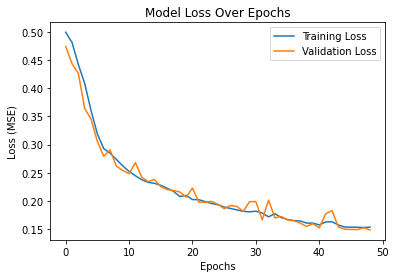

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [10]:
train_loss, train_mae = model.evaluate([train_ts, train_scalar], train_targets, verbose=0)
print(f"Training Set - Loss (MSE): {train_loss:.4f}, MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([val_ts, val_scalar], val_targets, verbose=0)
print(f"Validation Set - Loss (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}")
test_loss, test_mae = model.evaluate([test_ts, test_scalar], test_targets, verbose=0)
print(f"Test Set - Loss (MSE): {test_loss:.4f}, MAE: {test_mae:.4f}")

Training Set - Loss (MSE): 0.1489, MAE: 0.2412
Validation Set - Loss (MSE): 0.1487, MAE: 0.2384
Test Set - Loss (MSE): 0.1472, MAE: 0.2580


In [11]:
train_pred = model.predict([train_ts, train_scalar]).flatten()
val_pred = model.predict([val_ts, val_scalar]).flatten()
test_pred = model.predict([test_ts, test_scalar]).flatten()

In [12]:
def compute_class_metrics(true_t5, pred_t5, lb, ub):
    # Masks for true classes
    low_mask = true_t5 < lb
    normal_mask = (true_t5 >= lb) & (true_t5 <= ub)
    high_mask = true_t5 > ub
    
    # Masks for predicted classes
    pred_low = pred_t5 < lb
    pred_normal = (pred_t5 >= lb) & (pred_t5 <= ub)
    pred_high = pred_t5 > ub
    
    # Helper function to compute MAE and accuracy
    def get_metrics(mask, pred_class):
        if np.sum(mask) == 0:  # Handle empty classes
            return np.nan, np.nan
        mae = np.mean(np.abs(true_t5[mask] - pred_t5[mask]))
        accuracy = np.mean(pred_class[mask]) * 100  # Percentage
        return mae, accuracy
    
    # Compute metrics for each class
    low_mae, low_acc = get_metrics(low_mask, pred_low)
    normal_mae, normal_acc = get_metrics(normal_mask, pred_normal)
    high_mae, high_acc = get_metrics(high_mask, pred_high)
    
    return {
        'low': {'mae': low_mae, 'accuracy': low_acc},
        'normal': {'mae': normal_mae, 'accuracy': normal_acc},
        'high': {'mae': high_mae, 'accuracy': high_acc}
    }

In [13]:
def print_metrics(metrics, dataset_name):
    print(f"--- {dataset_name} ---")
    for class_name in ['low', 'normal', 'high']:
        mae = metrics[class_name]['mae']
        acc = metrics[class_name]['accuracy']
        if np.isnan(mae):
            print(f"{class_name.capitalize()}: No data points")
        else:
            print(f"{class_name.capitalize()}: MAE = {mae:.4f}, Accuracy = {acc:.2f}%")

In [14]:
# Compute metrics
train_metrics = compute_class_metrics(train_targets, train_pred, lb, ub)
val_metrics = compute_class_metrics(val_targets, val_pred, lb, ub)
test_metrics = compute_class_metrics(test_targets, test_pred, lb, ub)

# Print results
print_metrics(train_metrics, "Training Set")
print_metrics(val_metrics, "Validation Set")
print_metrics(test_metrics, "Test Set")

--- Training Set ---
Low: MAE = 0.2718, Accuracy = 76.96%
Normal: MAE = 0.2181, Accuracy = 91.70%
High: MAE = 0.4214, Accuracy = 55.35%
--- Validation Set ---
Low: MAE = 0.2681, Accuracy = 77.71%
Normal: MAE = 0.2136, Accuracy = 91.65%
High: MAE = 0.4331, Accuracy = 40.54%
--- Test Set ---
Low: MAE = 0.2529, Accuracy = 70.91%
Normal: MAE = 0.2486, Accuracy = 91.78%
High: MAE = 0.4362, Accuracy = 51.61%


Class Distribution for Training Set:
normal    4435
high       360
low        223
dtype: int64
Percentage:
normal    88.381825
high       7.174173
low        4.444002
dtype: float64

Class Distribution for Validation Set:
normal    945
high       78
low        52
dtype: int64
Percentage:
normal    87.906977
high       7.255814
low        4.837209
dtype: float64

Class Distribution for Test Set:
normal    961
high       81
low        34
dtype: int64
Percentage:
normal    89.312268
high       7.527881
low        3.159851
dtype: float64

Mean of Scalar Features by Class:
               0         1         2         3         4         5
class                                                             
high    0.458557  0.312527  0.536190  0.577961  0.322265  0.010653
low     0.457467  0.336850  0.487124  0.432392  0.467155  0.010436
normal  0.455130  0.322073  0.524535  0.506335  0.401179  0.010005

Standard Deviation of Scalar Features by Class:
               0         1         2     

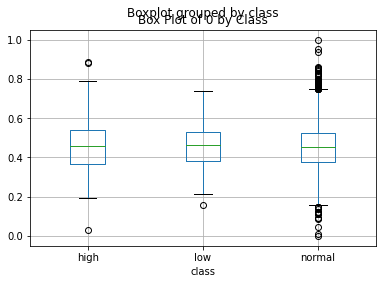

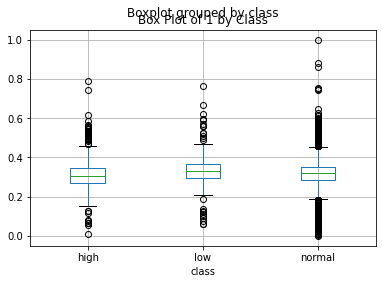

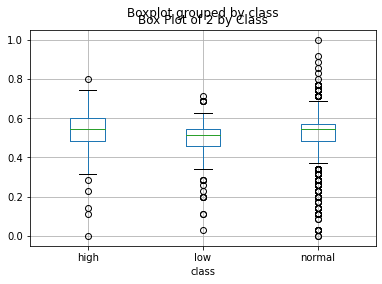

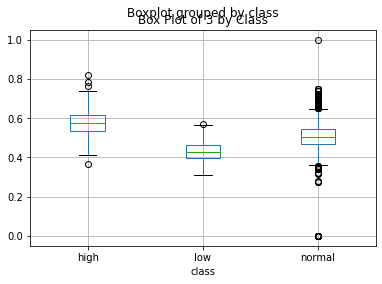

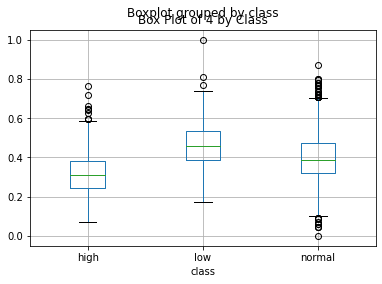

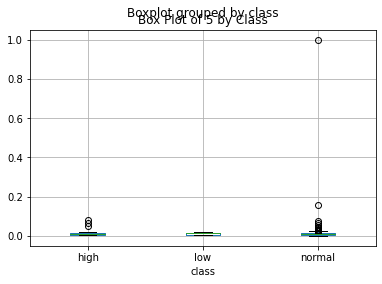

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to assign classes based on t5
def categorize_t5(t5):
    if t5 < lb:
        return 'low'
    elif lb <= t5 <= ub:
        return 'normal'
    else:
        return 'high'

# Analyze class distribution
def analyze_class_distribution(targets, dataset_name):
    classes = [categorize_t5(t) for t in targets]
    class_counts = pd.Series(classes).value_counts()
    print(f"Class Distribution for {dataset_name}:")
    print(class_counts)
    print(f"Percentage:\n{class_counts / len(targets) * 100}\n")

# Analyze scalar features
def analyze_scalar_features(scalar_features, targets):
    df = pd.DataFrame(scalar_features)
    df['class'] = [categorize_t5(t) for t in targets]
    
    # Compute mean and standard deviation by class
    means = df.groupby('class').mean()
    stds = df.groupby('class').std()
    
    print("Mean of Scalar Features by Class:")
    print(means)
    print("\nStandard Deviation of Scalar Features by Class:")
    print(stds)
    
    # Create box plots
    for col in df.columns[:-1]:  # Exclude 'class'
        df.boxplot(column=col, by='class')
        plt.title(f'Box Plot of {col} by Class')
        plt.show()

# Run the analysis
analyze_class_distribution(train_targets, "Training Set")
analyze_class_distribution(val_targets, "Validation Set")
analyze_class_distribution(test_targets, "Test Set")
analyze_scalar_features(train_scalar, train_targets)